Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

Load and explore the dataset

In [2]:
# Load the dataset
df = pd.read_csv('f1_strategy_modeling_dataset.csv')

# Display basic information
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nColumns:", df.columns.tolist())
print("\nData types:")
print(df.dtypes)

Dataset shape: (4553, 31)

First few rows:
   season  round              circuit           race_name     location  \
0    2018     10  Silverstone Circuit  British Grand Prix  Silverstone   
1    2018     10  Silverstone Circuit  British Grand Prix  Silverstone   
2    2018     10  Silverstone Circuit  British Grand Prix  Silverstone   
3    2018     10  Silverstone Circuit  British Grand Prix  Silverstone   
4    2018     10  Silverstone Circuit  British Grand Prix  Silverstone   

  country            driver driver_code  constructor tire_compound  ...  \
0      UK      Carlos Sainz         SAI      Renault        MEDIUM  ...   
1      UK      Carlos Sainz         SAI      Renault          HARD  ...   
2      UK  Daniel Ricciardo         RIC     Red Bull          SOFT  ...   
3      UK  Daniel Ricciardo         RIC     Red Bull        MEDIUM  ...   
4      UK      Esteban Ocon         OCO  Force India          SOFT  ...   

   fast_lap_attempts  position_changes  driver_aggr_score  \


Data preprocessing and cleaning

In [3]:
# Handle missing values
print("Missing values before cleaning:")
print(df.isnull().sum())

# Fill missing values for numerical columns with median
numerical_cols = df.select_dtypes(include=[np.number]).columns
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())

# Fill missing categorical values with mode
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0] if not df[col].mode().empty else 'Unknown')

print("\nMissing values after cleaning:")
print(df.isnull().sum())

Missing values before cleaning:
season                        0
round                         0
circuit                       0
race_name                   231
location                    231
country                     231
driver                        0
driver_code                   0
constructor                   0
tire_compound                 0
position                      0
stint                         0
stint_length                  0
pit_lap                       5
pit_time                      5
air_temp_c                  231
track_temp_c                231
humidity_pct                231
wind_kmh                    231
lap_time_variation            1
tire_usage_aggr               0
fast_lap_attempts             1
position_changes              0
driver_aggr_score             1
avg_pit_time_over_race        1
race_laps_reported            0
total_pitstops_reported       0
y1_next_stint_length          0
y2_next_compound              0
y3_next_pit_time           2527
race_key

Feature engineering and selection

In [4]:
# Select relevant features for LSTM model
features = [
    'season', 'round', 'position', 'stint', 'stint_length', 'pit_lap', 'pit_time',
    'air_temp_c', 'track_temp_c', 'humidity_pct', 'wind_kmh',
    'lap_time_variation', 'tire_usage_aggr', 'fast_lap_attempts',
    'position_changes', 'driver_aggr_score', 'avg_pit_time_over_race',
    'race_laps_reported', 'total_pitstops_reported'
]

# Encode categorical variables
categorical_to_encode = ['driver', 'constructor', 'tire_compound', 'circuit', 'country']
label_encoders = {}

for col in categorical_to_encode:
    if col in df.columns:
        le = LabelEncoder()
        df[col + '_encoded'] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le
        features.append(col + '_encoded')

print("Selected features:", features)
print("Number of features:", len(features))

Selected features: ['season', 'round', 'position', 'stint', 'stint_length', 'pit_lap', 'pit_time', 'air_temp_c', 'track_temp_c', 'humidity_pct', 'wind_kmh', 'lap_time_variation', 'tire_usage_aggr', 'fast_lap_attempts', 'position_changes', 'driver_aggr_score', 'avg_pit_time_over_race', 'race_laps_reported', 'total_pitstops_reported', 'driver_encoded', 'constructor_encoded', 'tire_compound_encoded', 'circuit_encoded', 'country_encoded']
Number of features: 24


Create sequences for LSTM function

In [5]:
def create_sequences(data, features, target, sequence_length=5):
    """
    Create sequences for LSTM training
    """
    X, y = [], []

    # Group by driver and race to create sequences within the same context
    grouped = data.groupby(['driver', 'season', 'round'])

    for name, group in grouped:
        group = group.sort_values('stint')  # Sort by stint to maintain temporal order

        if len(group) < sequence_length:
            continue

        group_values = group[features].values
        target_values = group[target].values

        for i in range(len(group_values) - sequence_length):
            X.append(group_values[i:(i + sequence_length)])
            y.append(target_values[i + sequence_length])

    return np.array(X), np.array(y)

Prepare target variable and sequences

In [6]:
# Let's predict next stint length (y1_next_stint_length) as our target
target_column = 'y1_next_stint_length'

# Filter out rows where target is missing
df_clean = df[df[target_column].notna()].copy()

print(f"Total sequences available: {len(df_clean)}")
print(f"Target variable distribution:")
print(df_clean[target_column].describe())

# Create sequences
sequence_length = 3  # Using 3 previous stints to predict the next
X, y = create_sequences(df_clean, features, target_column, sequence_length)

print(f"Created {len(X)} sequences with shape {X.shape}")
print(f"Target shape: {y.shape}")

Total sequences available: 4553
Target variable distribution:
count    4553.000000
mean       21.830441
std        12.901505
min         1.000000
25%        13.000000
50%        21.000000
75%        30.000000
max        77.000000
Name: y1_next_stint_length, dtype: float64
Created 187 sequences with shape (187, 3, 24)
Target shape: (187,)


Train-test split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Training set: (119, 3, 24), (119,)
Validation set: (30, 3, 24), (30,)
Test set: (38, 3, 24), (38,)


Feature scaling

In [8]:
# Scale features for better LSTM performance
scaler = StandardScaler()

# Reshape for scaling, then reshape back
X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
X_val_reshaped = X_val.reshape(-1, X_val.shape[-1])
X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])

# Fit scaler on training data only
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_val_scaled = scaler.transform(X_val_reshaped)
X_test_scaled = scaler.transform(X_test_reshaped)

# Reshape back to sequences
X_train_scaled = X_train_scaled.reshape(X_train.shape)
X_val_scaled = X_val_scaled.reshape(X_val.shape)
X_test_scaled = X_test_scaled.reshape(X_test.shape)

print("Data scaling completed")
print(f"Scaled training set shape: {X_train_scaled.shape}")

Data scaling completed
Scaled training set shape: (119, 3, 24)


Build LSTM model function

In [9]:
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=input_shape,
             dropout=0.2, recurrent_dropout=0.2),
        BatchNormalization(),

        LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
        BatchNormalization(),

        LSTM(32, dropout=0.2, recurrent_dropout=0.2),
        BatchNormalization(),

        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1)  # Regression output for stint length prediction
    ])

    return model

# Build model
input_shape = (X_train_scaled.shape[1], X_train_scaled.shape[2])
model = build_lstm_model(input_shape)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 3, 128)         │        78,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 3, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 3, 64)          │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 3, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,281 (567.50 KB)

 Trainable params: 144,833 (565.75 KB)

 Non-trainable params: 448 (1.75 KB)

None


Define callbacks

In [10]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.0001,
    verbose=1
)

Train the model

In [11]:
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 783ms/step - loss: 183.7231 - mae: 10.3419 - val_loss: 122.7779 - val_mae: 8.1284 - learning_rate: 0.0010
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 146.4895 - mae: 9.1630 - val_loss: 122.0649 - val_mae: 8.0845 - learning_rate: 0.0010
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 155.1012 - mae: 9.3057 - val_loss: 121.2860 - val_mae: 8.0354 - learning_rate: 0.0010
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 146.0395 - mae: 8.7779 - val_loss: 120.3615 - val_mae: 7.9779 - learning_rate: 0.0010
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 140.5346 - mae: 8.4359 - val_loss: 119.2929 - val_mae: 7.9108 - learning_rate: 0.0010
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 116.2541 - mae: 7.6771 - val_loss: 118.0646 - val_mae: 7.8336 - learning_rate: 0.0010
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 111.1272 - mae: 7.2921 - val_loss: 116.6256 - val_mae: 7.7425 - learning_ra

Plot training history

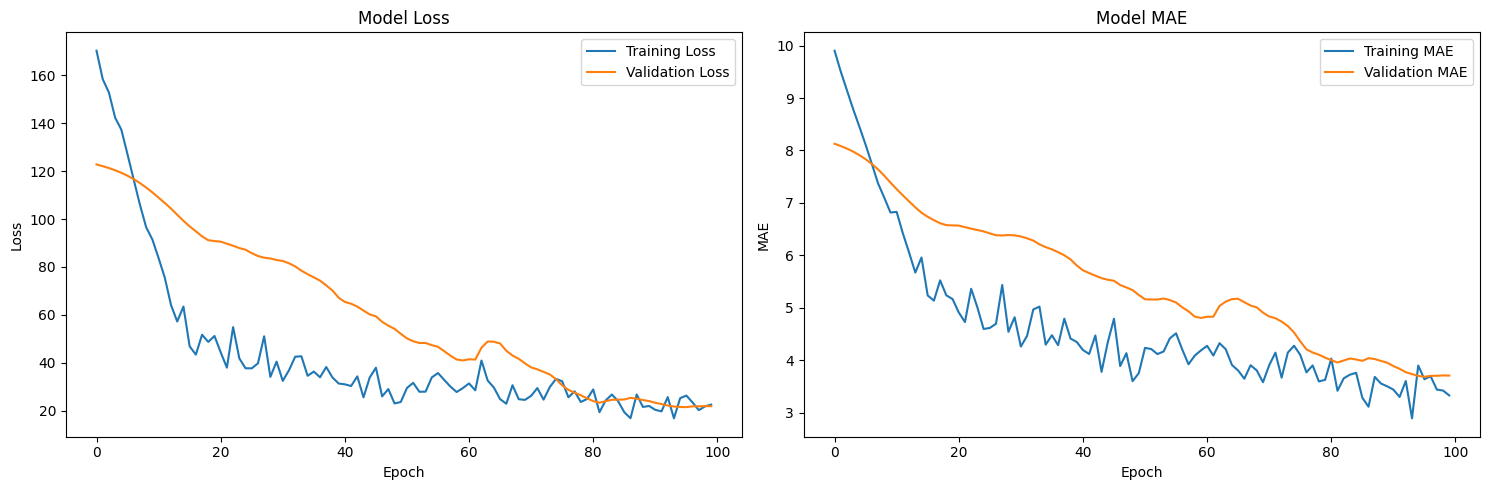

In [12]:
# Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

Make predictions and evaluate

In [13]:
y_pred = model.predict(X_test_scaled).flatten()

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(y_pred)
print(f"Test Set Performance:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step
[ 3.1988137 14.588688   5.119521  21.94595   11.803217   3.3938768
 11.043453   6.5919375  0.9136705  6.190325  12.487157  12.039043
 12.868682   5.364196   1.0939927  3.0446222  9.401411   1.6678166
  2.2319725 19.556728  15.391348   2.4118001  5.39618    9.428405
 11.069529   9.9630375 26.156666   2.715908   3.5594308 11.920315
 14.225115  14.489222   5.377821   5.3867474 12.458397   2.5061696
  3.129255   1.8252256]
Test Set Performance:
Mean Squared Error: 22.9575
Mean Absolute Error: 3.8766
R² Score: 0.5570


Visualize predictions vs actual

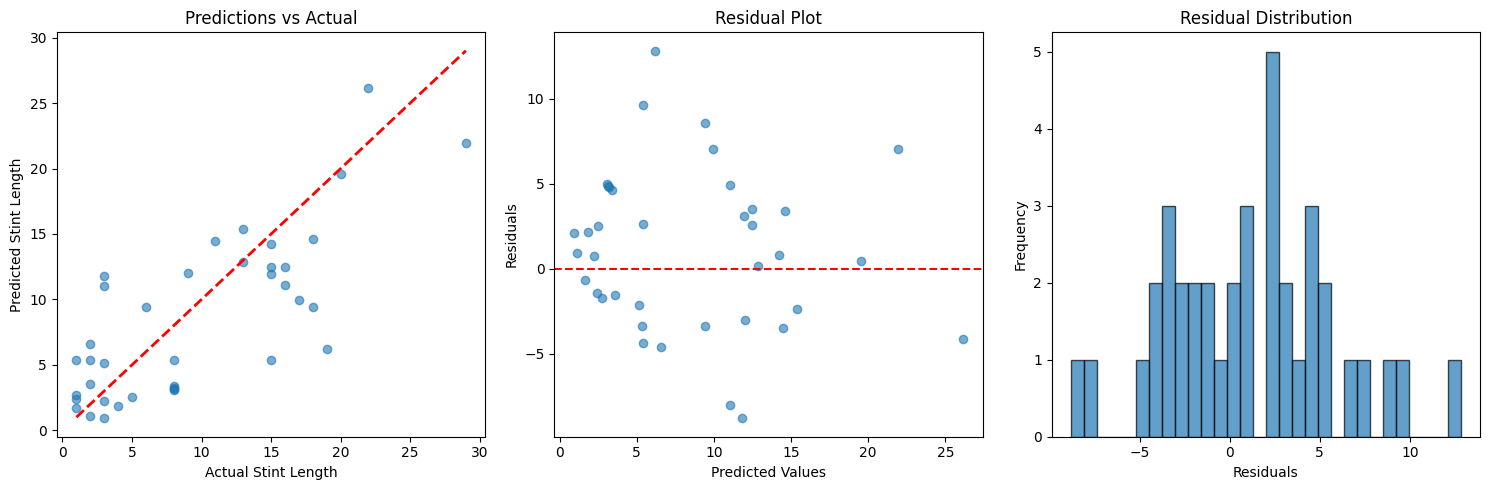

In [14]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Stint Length')
plt.ylabel('Predicted Stint Length')
plt.title('Predictions vs Actual')

plt.subplot(1, 3, 2)
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')

plt.subplot(1, 3, 3)
plt.hist(residuals, bins=30, alpha=0.7, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residual Distribution')

plt.tight_layout()
plt.show()

classification model to predict tire compound

In [15]:
# Prepare for tire compound classification
classification_target = 'tire_compound'

# Filter data for classification
df_class = df[df[classification_target].notna()].copy()

print(f"Available data for classification: {len(df_class)}")
print("Tire compound distribution:")
print(df_class[classification_target].value_counts())

def create_classification_sequences(data, features, target, sequence_length=3):
    """
    Create sequences for classification
    """
    X_cls, y_cls = [], []

    # Group by driver and race
    grouped = data.groupby(['driver', 'season', 'round'])

    for name, group in grouped:
        group = group.sort_values('stint')

        if len(group) < sequence_length:
            continue

        group_values = group[features].values
        target_values = group[target].values

        for i in range(len(group_values) - sequence_length):
            X_cls.append(group_values[i:(i + sequence_length)])
            y_cls.append(target_values[i + sequence_length])

    return np.array(X_cls), np.array(y_cls)

# Create classification sequences
X_cls, y_cls = create_classification_sequences(df_class, features, classification_target, sequence_length=3)

print(f"Classification sequences: {X_cls.shape}")
print(f"Target classes: {y_cls.shape}")
print("Class distribution:")
unique, counts = np.unique(y_cls, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"  {cls}: {count} samples")

Available data for classification: 4553
Tire compound distribution:
tire_compound
MEDIUM          1889
HARD            1042
SOFT             999
INTERMEDIATE     326
ULTRASOFT         98
SUPERSOFT         90
WET               67
HYPERSOFT         42
Name: count, dtype: int64
Classification sequences: (187, 3, 24)
Target classes: (187,)
Class distribution:
  HARD: 33 samples
  INTERMEDIATE: 50 samples
  MEDIUM: 38 samples
  SOFT: 63 samples
  WET: 3 samples


Encode Target Labels

In [16]:
# Encode tire compound labels
label_encoder = LabelEncoder()
y_cls_encoded = label_encoder.fit_transform(y_cls)

print("Class mapping:")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"  {i} -> {class_name}")

# Train-test split for classification
X_cls_train, X_cls_test, y_cls_train, y_cls_test = train_test_split(
    X_cls, y_cls_encoded, test_size=0.2, random_state=42, stratify=y_cls_encoded
)

X_cls_train, X_cls_val, y_cls_train, y_cls_val = train_test_split(
    X_cls_train, y_cls_train, test_size=0.2, random_state=42, stratify=y_cls_train
)

print(f"Classification training: {X_cls_train.shape}")
print(f"Classification validation: {X_cls_val.shape}")
print(f"Classification test: {X_cls_test.shape}")

Class mapping:
  0 -> HARD
  1 -> INTERMEDIATE
  2 -> MEDIUM
  3 -> SOFT
  4 -> WET
Classification training: (119, 3, 24)
Classification validation: (30, 3, 24)
Classification test: (38, 3, 24)


Scale Features for Classification

In [17]:
# Scale features for classification model
scaler_cls = StandardScaler()

# Reshape for scaling
X_cls_train_reshaped = X_cls_train.reshape(-1, X_cls_train.shape[-1])
X_cls_val_reshaped = X_cls_val.reshape(-1, X_cls_val.shape[-1])
X_cls_test_reshaped = X_cls_test.reshape(-1, X_cls_test.shape[-1])

# Fit scaler
X_cls_train_scaled = scaler_cls.fit_transform(X_cls_train_reshaped)
X_cls_val_scaled = scaler_cls.transform(X_cls_val_reshaped)
X_cls_test_scaled = scaler_cls.transform(X_cls_test_reshaped)

# Reshape back
X_cls_train_scaled = X_cls_train_scaled.reshape(X_cls_train.shape)
X_cls_val_scaled = X_cls_val_scaled.reshape(X_cls_val.shape)
X_cls_test_scaled = X_cls_test_scaled.reshape(X_cls_test.shape)

print("Classification data scaling completed")

Classification data scaling completed


Build Classification LSTM Model

In [18]:
def build_lstm_classifier(input_shape, num_classes):
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=input_shape,
             dropout=0.2, recurrent_dropout=0.2),
        BatchNormalization(),

        LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
        BatchNormalization(),

        LSTM(32, dropout=0.2, recurrent_dropout=0.2),
        BatchNormalization(),

        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')  # Multi-class classification
    ])

    return model

# Build classification model
num_classes = len(label_encoder.classes_)
input_shape_cls = (X_cls_train_scaled.shape[1], X_cls_train_scaled.shape[2])
model_cls = build_lstm_classifier(input_shape_cls, num_classes)

# Compile for classification
model_cls.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print(model_cls.summary())
print(f"Number of classes: {num_classes}")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 3, 128)         │        78,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 3, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 3, 64)          │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 3, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,413 (568.02 KB)

 Trainable params: 144,965 (566.27 KB)

 Non-trainable params: 448 (1.75 KB)

None
Number of classes: 5


Train Classification Model

In [19]:
# Callbacks for classification
early_stopping_cls = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_cls = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=5,
    min_lr=0.0001,
    verbose=1
)

# Train classification model
history_cls = model_cls.fit(
    X_cls_train_scaled, y_cls_train,
    validation_data=(X_cls_val_scaled, y_cls_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping_cls, reduce_lr_cls],
    verbose=1
)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 586ms/step - accuracy: 0.3098 - loss: 1.5654 - val_accuracy: 0.3333 - val_loss: 1.6048 - learning_rate: 0.0010
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.3111 - loss: 1.6342 - val_accuracy: 0.3000 - val_loss: 1.5994 - learning_rate: 0.0010
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.3120 - loss: 1.4677 - val_accuracy: 0.3667 - val_loss: 1.5935 - learning_rate: 0.0010
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.3024 - loss: 1.5325 - val_accuracy: 0.3667 - val_loss: 1.5888 - learning_rate: 0.0010
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4532 - loss: 1.2796 - val_accuracy: 0.3667 - val_loss: 1.5839 - learning_rate: 0.0010
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.4791 - loss: 1.3321 - val_accuracy: 0.3667 - val_loss: 1.5786 - learning_rate: 0.0010
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4470 - loss: 1.3380 - val_accuracy: 0.400

Evaluate Classification Model

In [23]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

# Make predictions
y_cls_pred_proba = model_cls.predict(X_cls_test_scaled)
y_cls_pred = np.argmax(y_cls_pred_proba, axis=1)

final_val_loss = history_cls.history['val_loss'][-1]
final_val_accuracy = history_cls.history['val_accuracy'][-1]

# Calculate metrics
accuracy = np.mean(y_cls_pred == y_cls_test)
precision = precision_score(y_cls_test, y_cls_pred, average='weighted')
recall = recall_score(y_cls_test, y_cls_pred, average='weighted')
f1 = f1_score(y_cls_test, y_cls_pred, average='weighted')

print("CLASSIFICATION RESULTS:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

print(f"Validation Loss: {final_val_loss:.4f}")
print(f"Validation Accuracy: {final_val_accuracy:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
CLASSIFICATION RESULTS:
Accuracy: 0.4474
Precision: 0.5846
Recall: 0.4474
F1-Score: 0.4103
Validation Loss: 1.4481
Validation Accuracy: 0.3667


Plot Classification Results

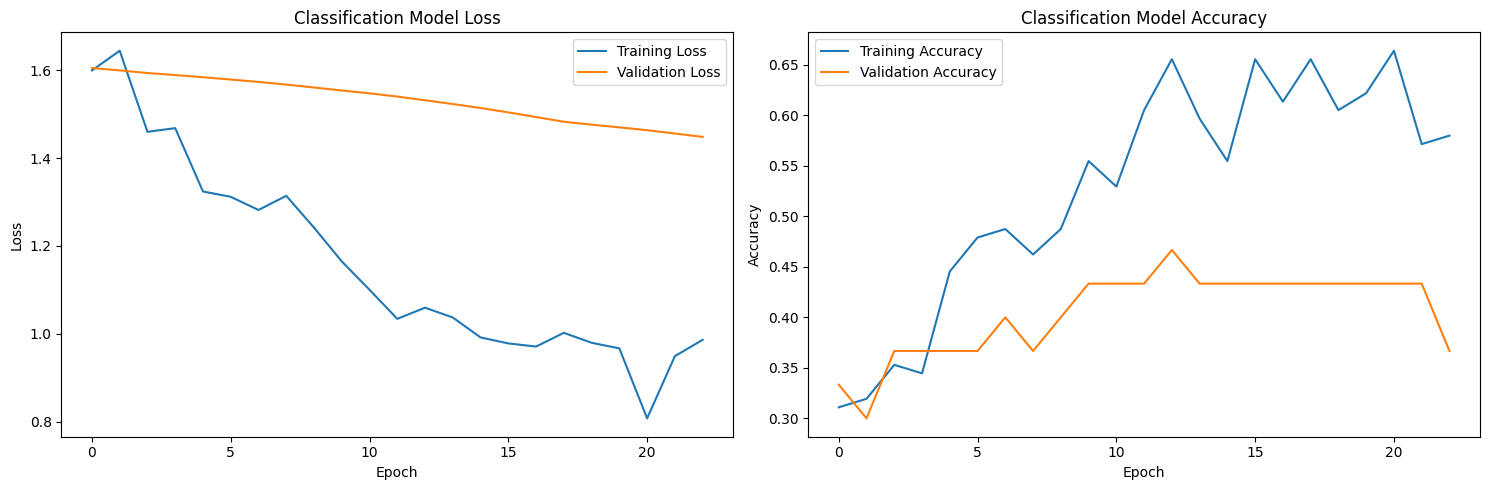

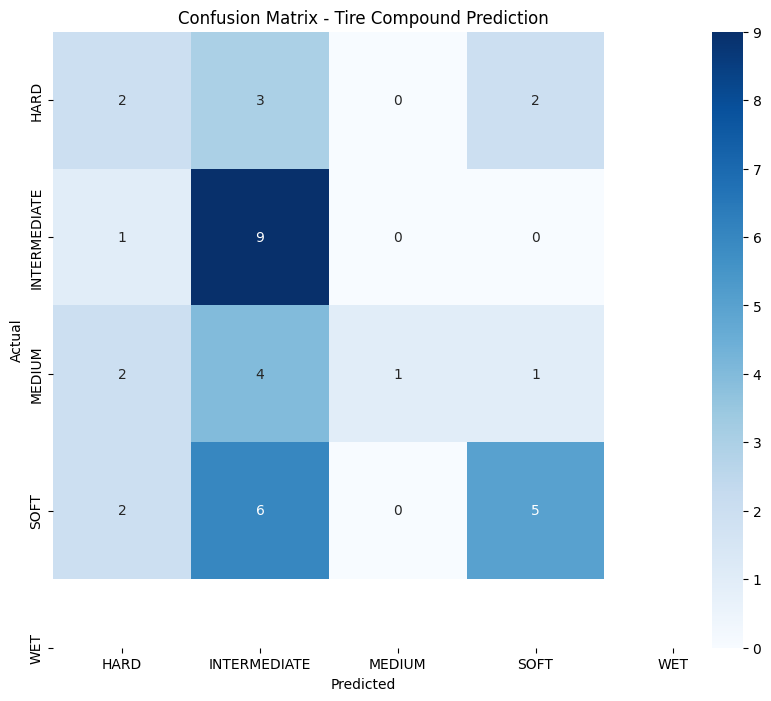

In [24]:
# Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history_cls.history['loss'], label='Training Loss')
plt.plot(history_cls.history['val_loss'], label='Validation Loss')
plt.title('Classification Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cls.history['accuracy'], label='Training Accuracy')
plt.plot(history_cls.history['val_accuracy'], label='Validation Accuracy')
plt.title('Classification Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_cls_test, y_cls_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - Tire Compound Prediction')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()